In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import morphology, filters, exposure, util, measure, segmentation
from scipy import ndimage, stats

In [2]:
def window_transform(ct_array, windowWidth, windowCenter, normal=False):
    """
    return: trucated image according to window center and window width
    and normalized to [0,1]
    """
    minWindow = float(windowCenter) - 0.5*float(windowWidth)
    # print(minWindow)
    newimg = (ct_array - minWindow) / float(windowWidth)
    newimg[newimg < 0] = 0
    newimg[newimg > 1] = 1
    if not normal:
        newimg = (newimg * 255).astype('uint8')
    return newimg

In [3]:
def show_img(img, cmap=None, title=None):
    plt.figure(dpi=100)
    # plt.margins(0,0)
    # plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0)
    plt.title(label=title)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.axis('off')
    # plt.savefig("img-test.png", dpi=150)
    plt.show()

In [12]:
def lung_crop(ct_image, is_show=False):
    threshold = filters.threshold_isodata(ct_image)
    # threshold = Huang_threshold(ct_image)
    print(threshold)
    # filters.try_all_threshold(ct_image)
    binary = ct_image >= threshold
    if is_show:
        show_img(binary, cmap="gray")

    img = measure.label(binary, connectivity=2)
    props = measure.regionprops(img)
    # 最大区域获取
    max_area = 0
    max_index = 0
    # props只包含像素值不为零区域的属性，因此index要从1开始
    for index, prop in enumerate(props, start=1):
        if prop.area > max_area:
            max_area = prop.area
            # index 代表每个联通区域内的像素值；prop.area代表相应连通区域内的像素个数
            max_index = index

    img[img != max_index] = False
    img[img == max_index] = True
    if is_show:
        show_img(img, cmap="gray")


    tmp_img = morphology.skeletonize(img)
    if is_show:
        show_img(tmp_img, cmap="gray")
    # tmp_img1 = morphology.thin(img)
    # if is_show:
    #     show_img(tmp_img1, cmap="gray", title="thin")
    # tmp_img1 = morphology.skeletonize(img)
    # if is_show:
    #     show_img(tmp_img1, cmap="gray", title="skeletonize")

    tmp_img = ndimage.binary_fill_holes(tmp_img)
    if is_show:
        show_img(tmp_img, cmap="gray")
    tmp_img = morphology.binary_opening(tmp_img, selem=morphology.square(4))
    if is_show:
        show_img(tmp_img, cmap="gray")
    # tmp_img = morphology.convex_hull_image(tmp_img, tolerance=50)
    # if is_show:
    #     show_img(tmp_img, cmap="gray", title="convex")


    img = measure.label(tmp_img, connectivity=2)
    props = measure.regionprops(img)
    # 最大区域获取
    max_area = 0
    max_index = 0
    # props只包含像素值不为零区域的属性，因此index要从1开始
    for index, prop in enumerate(props, start=1):
        if prop.area > max_area:
            max_area = prop.area
            # index 代表每个联通区域内的像素值；prop.area代表相应连通区域内的像素个数
            max_index = index
            minr, minc, maxr, maxc = prop.bbox

    img[img != max_index] = False
    img[img == max_index] = True
    if is_show:
        show_img(img, cmap="gray")
    print(minr, minc, maxr, maxc)
    # 136 7 457 512
    if is_show:
        fig, ax = plt.subplots(dpi=100)
        ax.axis("off")
        ax.imshow(ct_image, cmap="gray")
        # RGB_img = np.zeros(shape=(ct_image.shape[0], ct_image.shape[1], 3))
        # RGB_img[:, :, 1] = img
        # print(np.unique(RGB_img))
        # ax.imshow(RGB_img, alpha=0.3)
        rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_artist(rect)
        plt.show()
    tmp_ct = ct_image[minr:maxr+1, minc: maxc+1]
    if is_show:
        show_img(tmp_ct, cmap="gray")
        
    equ = exposure.equalize_hist(tmp_ct)
    show_img(equ, cmap="gray", title="hist")
    print(np.max(equ), np.min(equ))

In [5]:
data_path = "F:\\ROOT\\pyproject\\covid_new\\data_example\\seg\\ct_scans"
# ct_path = "E:\\dataset\\COVID-19-CT-Seg_20cases\\ct_scans\\coronacases_001.nii.gz"
ct_path = "F:\\ROOT\\pyproject\\covid_new\\data_example\\seg\\ct_scans\\tr_im.nii.gz"
# ct_path = "E:\\dataset\\COVID-19-50\\ct_scans\\study_0258.nii.gz"
infection_path = "F:\\ROOT\\pyproject\\covid_new\\data_example\\seg\\infection_masks\\tr_im.nii.gz"

In [6]:
ct = sitk.ReadImage(ct_path)

(100, 512, 512)


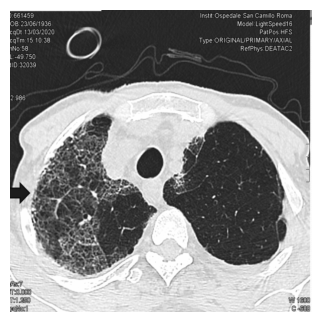

132


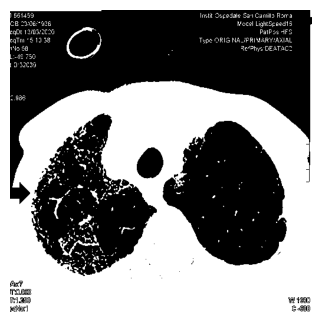

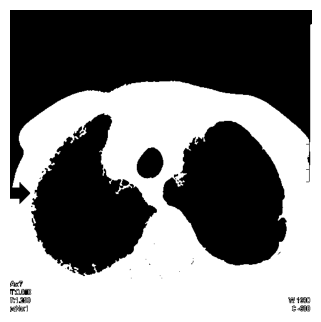

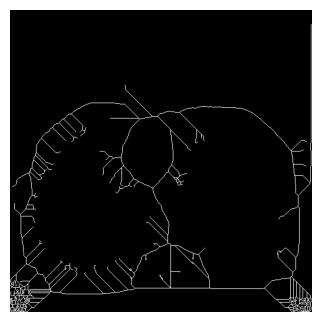

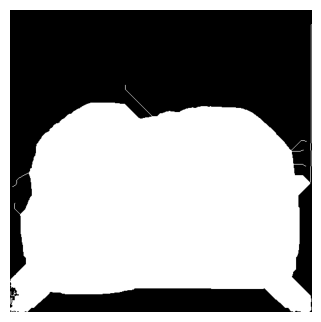

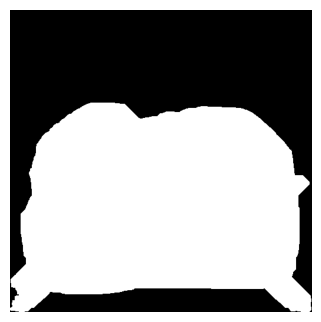

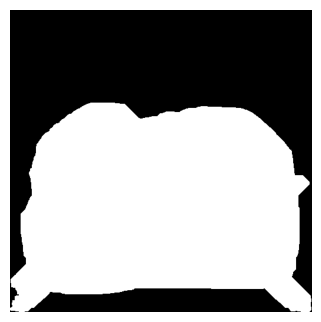

157 0 512 511


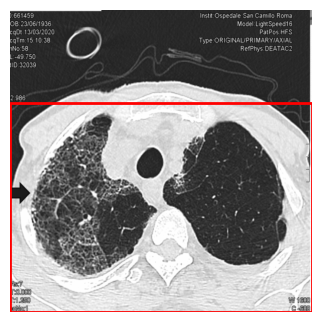

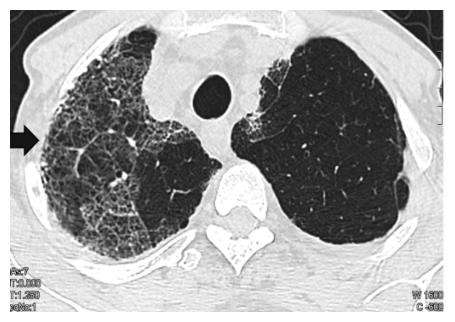

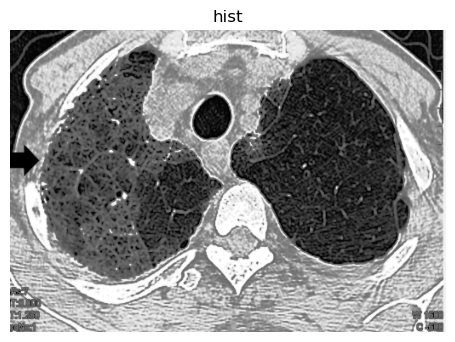

1.0 1.1003521126760564e-05


In [13]:
ct_array = sitk.GetArrayFromImage(ct)
print(ct_array.shape)
# ct_array = window_transform(ct_array*1.0, 500, 300)
ct_array = window_transform(ct_array*1.0, 1500, -500)

ct_image = ct_array[15]
show_img(ct_image, cmap="gray")
# ct_image = ct_array[100]
lung_crop(ct_image, True)


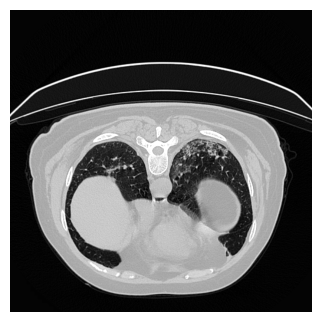

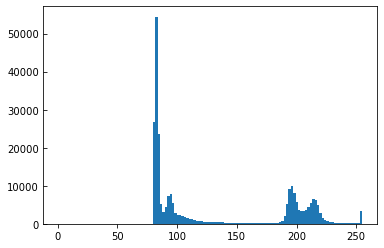

In [86]:
# fig, ax = plt.subplots()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'out'
show_img(ct_image, cmap="gray")
plt.hist(ct_image.flatten(), bins=128, range=(0, 255))
plt.show()

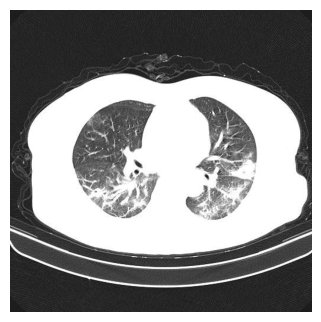

(512, 512)
(512, 512)
[0 1 2 3]
uint8


In [19]:
idx = 107
slice_idx = 64
img = Image.open("E:\\dataset\\ct_lesion_seg\\image\\{}\\{}.jpg".format(idx, slice_idx))

gray_img = img.convert('L')

# 将图像转换为Numpy数组
show_img(gray_img, cmap="gray")
img_arr = np.array(gray_img)
print(img_arr.shape)
# lung_crop(img_arr, True)
mask = Image.open("E:\\dataset\\ct_lesion_seg\\mask\\{}\\{}.png".format(idx, slice_idx))
gray_mask = mask.convert("L")
gray_arr = np.array(gray_mask)
print(gray_arr.shape)
print(np.unique(gray_arr))
print(gray_arr.dtype)
# print(ct_image[0][0])
# plt.rcParams['ytick.direction'] = 'in'
# plt.rcParams['xtick.direction'] = 'out'
# plt.hist(img_arr.flatten(), bins=256, range=(0, 255))
# plt.show()